# Introduction
This notebook provides an introduction for a simple linear regression. With a dataset containing several output records of a solar farm and temperature measurements. We are building a model which is able to predict the daily output with a temperature value as input. This is an excellent case study as it represents a real world problem and includes some data preparation in advance.

A simple linear regression discovers the relationship between two variables. A so called independent variable X, which is used for predictions, in our case  temperature values and a dependent variable Y which is the value of interest, our output values. The math behind it is quite straight forward: 
$$ Y = a + bX$$
In addition to Y and X we are adding an intercept a, which is a constant. The intercept would be Y if X is zero. And a slope b which defines how strong Y rises or falls when X changes.

# Data Inspection

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [16]:
df_plant = pd.read_csv('./data/Plant_1_Generation_Data.csv')
df_sensor = pd.read_csv('./data/Plant_1_Weather_Sensor_Data.csv')

In [17]:
df_plant['DATE_TIME'] = pd.to_datetime(df_plant['DATE_TIME'])
df_sensor['DATE_TIME'] = pd.to_datetime(df_sensor['DATE_TIME'])

In [18]:
df_plant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB


In [19]:
df_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


Our dependent variable Y is the column DC_POWER in df_plant and the independent variable X is represented by the column AMBIENT_TEMPERATURE in df_sensor.

# Data Cleaning

We want to make daily predictions, so we have to do some aggregations and finally merge the two data sets together.

In [20]:
df_pl_gr = df_plant.groupby('DATE_TIME').sum()
df_pl_gr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3158 entries, 2020-01-06 00:00:00 to 2020-12-06 23:45:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLANT_ID     3158 non-null   int64  
 1   DC_POWER     3158 non-null   float64
 2   AC_POWER     3158 non-null   float64
 3   DAILY_YIELD  3158 non-null   float64
 4   TOTAL_YIELD  3158 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 148.0 KB


In [21]:
df_pl_gr = df_pl_gr.reset_index().groupby(pd.Grouper(key='DATE_TIME',freq='D')).sum()

In [22]:
df_se_gr = df_sensor.groupby(['DATE_TIME']).mean()
df_se_gr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3182 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLANT_ID             3182 non-null   float64
 1   AMBIENT_TEMPERATURE  3182 non-null   float64
 2   MODULE_TEMPERATURE   3182 non-null   float64
 3   IRRADIATION          3182 non-null   float64
dtypes: float64(4)
memory usage: 124.3 KB


In [23]:
df_se_gr = df_se_gr.reset_index().groupby(pd.Grouper(key='DATE_TIME',freq='D')).mean()

## Merging x and y

In [24]:
df_se_gr.head()

,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,
2020-05-15,4135001.0,27.430823,32.582964,0.204699
2020-05-16,4135001.0,26.780538,31.858851,0.211951
2020-05-17,4135001.0,26.686727,32.740435,0.238869
2020-05-18,4135001.0,23.850938,27.814344,0.159026
2020-05-19,4135001.0,25.338021,29.725163,0.194031


In [25]:
df_pl_gr.head()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-01-06,8733122112,5.210134e+06,509691.499996,6.387988e+06,1.474426e+10
2020-01-07,0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2020-01-08,0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2020-01-09,0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2020-01-10,0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


In [26]:
df_merged = df_pl_gr.merge(df_se_gr, left_on='DATE_TIME', right_on='DATE_TIME')

In [27]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2020-05-15 to 2020-06-17
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLANT_ID_x           34 non-null     int64  
 1   DC_POWER             34 non-null     float64
 2   AC_POWER             34 non-null     float64
 3   DAILY_YIELD          34 non-null     float64
 4   TOTAL_YIELD          34 non-null     float64
 5   PLANT_ID_y           34 non-null     float64
 6   AMBIENT_TEMPERATURE  34 non-null     float64
 7   MODULE_TEMPERATURE   34 non-null     float64
 8   IRRADIATION          34 non-null     float64
dtypes: float64(8), int64(1)
memory usage: 2.7 KB


In [28]:
df_final = df_merged[['DC_POWER', 'AMBIENT_TEMPERATURE']]
df_final = df_final.loc[df_final['DC_POWER'] != 0]

<AxesSubplot:xlabel='AMBIENT_TEMPERATURE', ylabel='DC_POWER'>

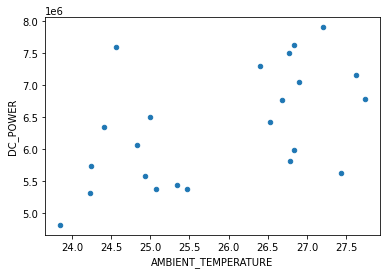

In [29]:
df_final.plot.scatter(x='AMBIENT_TEMPERATURE', y='DC_POWER')

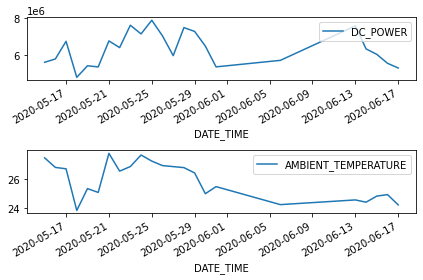

In [30]:
figure, axes = plt.subplots(2, 1)
df_final.plot.line(y='DC_POWER', ax=axes[0])
df_final.plot.line(y='AMBIENT_TEMPERATURE', ax=axes[1])
figure.tight_layout()
plt.show()

By looking at the line charts above you can already see a similar trend which indicates a linear relationship.

# Model Building

In [31]:
model = LinearRegression()
model.fit(df_final[["AMBIENT_TEMPERATURE"]], df_final["DC_POWER"])

LinearRegression()

In [32]:
fitted = model.predict(df_final[["AMBIENT_TEMPERATURE"]])

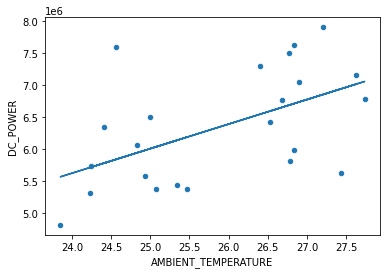

In [33]:
ax = df_final.plot.scatter(x='AMBIENT_TEMPERATURE', y='DC_POWER')
ax.plot(df_final["AMBIENT_TEMPERATURE"], fitted)

# Evaluation

In [34]:
RMSE = np.sqrt(mean_squared_error(df_final["DC_POWER"], fitted))
r2 = r2_score(df_final["DC_POWER"], fitted)
print(f'RMSE: {RMSE}')
print(f'r2: {r2}')

RMSE: 738870.297286123
r2: 0.28315553491514034


Text(0, 0.5, 'Predicted Output')

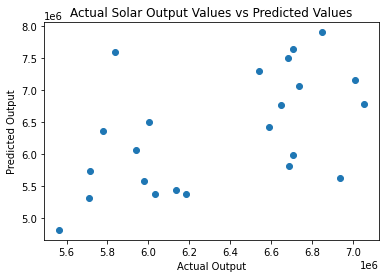

In [35]:
plt.scatter(fitted, df_final['DC_POWER'])
plt.title('Actual Solar Output Values vs Predicted Values')
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')

# Final Thoughts

After preparing the data set, building the model and evaluating it, we have to derive a conclusion. We devinitly catched a linear relationship on both variables, but for building an accurate model we need more data records. As we are dealing with timestamps with seasonal differences at least one full year is necessary to create a reasonable model. 